# Covid Self Test Model Based on Symptoms and Realted Factors

### Upgrading and Importing Relevant packages

In [ ]:
!pip install --upgrade xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from imblearn.combine import SMOTETomek
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

### Reading the Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project/Data/corona_tested_individuals_ver_006.english.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   test_date            278848 non-null  object
 1   cough                278848 non-null  object
 2   fever                278848 non-null  object
 3   sore_throat          278848 non-null  object
 4   shortness_of_breath  278848 non-null  object
 5   head_ache            278848 non-null  object
 6   corona_result        278848 non-null  object
 7   age_60_and_above     278848 non-null  object
 8   gender               278848 non-null  object
 9   test_indication      278848 non-null  object
dtypes: object(10)
memory usage: 21.3+ MB


In [ ]:
df['cough'].value_counts()

0       121649
0       114719
1        25875
1        16353
None       252
Name: cough, dtype: int64

In [ ]:
df.loc[df['cough'] == 'None']

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
181160,2020-04-05,None,None,0,0,0,negative,No,male,Other
184426,2020-04-04,None,None,0,0,0,negative,Yes,female,Other
184428,2020-04-04,None,None,0,0,0,negative,No,male,Other
184429,2020-04-04,None,None,0,0,0,positive,Yes,female,Other
184430,2020-04-04,None,None,0,0,0,negative,Yes,male,Other
...,...,...,...,...,...,...,...,...,...,...
275570,2020-03-16,None,None,0,0,0,negative,None,None,Other
276081,2020-03-15,None,None,0,0,0,negative,None,None,Other
278203,2020-03-12,None,None,None,None,None,positive,None,None,Other
278622,2020-03-11,None,0,1,0,0,positive,None,None,Abroad


In [ ]:
df['fever'].value_counts()

0       133942
0       122902
1        13582
1         8170
None       252
Name: fever, dtype: int64

In [ ]:
df['sore_throat'].value_counts()

0       260664
0        16257
1         1480
1          446
None         1
Name: sore_throat, dtype: int64

In [ ]:
df['shortness_of_breath'].value_counts()

0       261079
0        16191
1         1065
1          512
None         1
Name: shortness_of_breath, dtype: int64

In [ ]:
df['head_ache'].value_counts()

0       260079
0        16354
1         2065
1          349
None         1
Name: head_ache, dtype: int64

In [ ]:
df['corona_result'].value_counts()

negative    260227
positive     14729
other         3892
Name: corona_result, dtype: int64

In [ ]:
df.loc[df['corona_result'] == 'other']

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
67,2020-04-30,0,1,0,0,0,other,None,female,Other
437,2020-04-30,0,0,0,0,0,other,None,male,Other
883,2020-04-30,0,0,0,0,0,other,None,female,Other
1101,2020-04-30,0,0,0,0,0,other,None,female,Other
1580,2020-04-30,0,0,0,0,0,other,None,male,Other
...,...,...,...,...,...,...,...,...,...,...
278625,2020-03-11,1,0,0,0,0,other,None,None,Other
278694,2020-03-11,0,0,0,0,0,other,None,None,Other
278710,2020-03-11,0,0,0,0,0,other,None,None,Other
278796,2020-03-11,1,0,0,0,0,other,None,None,Other


In [ ]:
df['test_indication'].value_counts()

Other                     242741
Abroad                     25468
Contact with confirmed     10639
Name: test_indication, dtype: int64

In [ ]:
df['age_60_and_above'].value_counts()

None    127320
No      125703
Yes      25825
Name: age_60_and_above, dtype: int64

In [ ]:
df['gender'].value_counts()

female    130158
male      129127
None       19563
Name: gender, dtype: int64

Although no columns contain NAN values, several columns contain techinical null values in the form of None

In [ ]:
df.loc[(df['age_60_and_above'] == 'Yes') & (df['corona_result'] == 'positive')]

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
122945,2020-04-14,0,0,0,0,0,positive,Yes,female,Contact with confirmed
123092,2020-04-14,1,0,0,0,0,positive,Yes,male,Contact with confirmed
123129,2020-04-14,0,0,0,0,0,positive,Yes,male,Abroad
123138,2020-04-14,1,1,0,0,0,positive,Yes,male,Other
123260,2020-04-14,1,1,0,0,0,positive,Yes,female,Contact with confirmed
...,...,...,...,...,...,...,...,...,...,...
273996,2020-03-17,1,1,0,1,0,positive,Yes,None,Abroad
274090,2020-03-17,1,1,0,0,0,positive,Yes,None,Other
274186,2020-03-17,0,0,0,0,0,positive,Yes,None,Other
274202,2020-03-17,0,0,0,0,0,positive,Yes,None,Other


In [ ]:
df.loc[df['corona_result'] == 'other'].index

Int64Index([    67,    437,    883,   1101,   1580,   1635,   1684,   1931,
              2367,   3082,
            ...
            278106, 278224, 278559, 278583, 278609, 278625, 278694, 278710,
            278796, 278846],
           dtype='int64', length=3892)

In [ ]:
df.drop(df.loc[df['corona_result'] == 'other'].index, inplace = True)

In [ ]:
df['cough'].value_counts()

0       119702
0       113431
1        25547
1        16024
None       252
Name: cough, dtype: int64

In [ ]:
df['age_60_and_above'].value_counts()

None    125664
No      123867
Yes      25425
Name: age_60_and_above, dtype: int64

In [ ]:
len(df.loc[df['age_60_and_above'] == 'None'].index)

125664

#### Filling none values with Random Sample Imputation

In [ ]:
random_age_values = df['age_60_and_above'].drop(
    df.loc[df['age_60_and_above'] == 'None'].index
).sample(len(df.loc[df['age_60_and_above'] == 'None'].index))

In [ ]:
random_age_values.index = df.loc[df['age_60_and_above'] == 'None'].index

In [ ]:
df['age_60_and_above'] = df['age_60_and_above'].replace(to_replace='None', value = np.nan)

In [ ]:
df['age_60_and_above'].isnull().sum()

125664

In [ ]:
df['age_60_and_above'] = df['age_60_and_above'].fillna(random_age_values)

In [ ]:
df['age_60_and_above'].value_counts()

No     228122
Yes     46834
Name: age_60_and_above, dtype: int64

In [ ]:
df['gender'] = df['gender'].replace(to_replace='None', value='Other')

In [ ]:
df['gender'].value_counts()

female    128541
male      127370
Other      19045
Name: gender, dtype: int64

In [ ]:
df['cough'].replace(to_replace='None', value=np.nan, inplace = True)

In [ ]:
random_cough = df['cough'].dropna().sample(df['cough'].isnull().sum())

In [ ]:
random_cough.index = df[df['cough'].isnull()].index

In [ ]:
df['cough'] = df['cough'].fillna(random_cough)

In [ ]:
df['cough'].isnull().sum()

0

In [ ]:
df['cough'].value_counts()

0    119818
0    113540
1     25561
1     16037
Name: cough, dtype: int64

In [ ]:
df['cough'] = pd.to_numeric(df['cough'])

In [ ]:
df['cough'].dtype

dtype('int64')

In [ ]:
df['cough'].value_counts()

0    233358
1     41598
Name: cough, dtype: int64

In [ ]:
df['fever'].replace(to_replace='None', value=np.nan, inplace = True)
random_fever = df['fever'].dropna().sample(df['fever'].isnull().sum())
random_fever.index = df[df['fever'].isnull()].index
df['fever'] = df['fever'].fillna(random_fever)

In [ ]:
df['fever'].isnull().sum()

0

In [ ]:
df['fever'].value_counts()

0    253566
1     21390
Name: fever, dtype: int64

In [ ]:
df['fever'] = pd.to_numeric(df['fever'])

In [ ]:
df.loc[df['sore_throat'] == 'None']

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
278203,2020-03-12,0,0,None,None,None,positive,No,Other,Other


In [ ]:
df.drop(index=278203, inplace = True)

#### Changing Datatype

In [ ]:
df['sore_throat'] = pd.to_numeric(df['sore_throat'])
df['shortness_of_breath'] = pd.to_numeric(df['shortness_of_breath'])
df['head_ache'] = pd.to_numeric(df['head_ache'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274955 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   test_date            274955 non-null  object
 1   cough                274955 non-null  int64 
 2   fever                274955 non-null  int64 
 3   sore_throat          274955 non-null  int64 
 4   shortness_of_breath  274955 non-null  int64 
 5   head_ache            274955 non-null  int64 
 6   corona_result        274955 non-null  object
 7   age_60_and_above     274955 non-null  object
 8   gender               274955 non-null  object
 9   test_indication      274955 non-null  object
dtypes: int64(5), object(5)
memory usage: 23.1+ MB


In [ ]:
df.reset_index(drop = True, inplace = True)

#### Writing to new CSV

In [ ]:
#df.to_csv('/content/drive/MyDrive/Project/Data/cleaned_symptoms.csv')

### Encoding

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project/Data/cleaned_symptoms.csv')

In [ ]:
df.head()

,Unnamed: 0,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,0,2020-04-30,0,0,0,0,0,negative,No,female,Other
1,1,2020-04-30,1,0,0,0,0,negative,No,female,Other
2,2,2020-04-30,0,1,0,0,0,negative,No,male,Other
3,3,2020-04-30,1,0,0,0,0,negative,Yes,female,Other
4,4,2020-04-30,1,0,0,0,0,negative,No,male,Other


In [ ]:
df.drop(columns=['Unnamed: 0', 'test_date'], axis = 1, inplace = True)

In [ ]:
df.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,0,0,0,0,0,negative,No,female,Other
1,1,0,0,0,0,negative,No,female,Other
2,0,1,0,0,0,negative,No,male,Other
3,1,0,0,0,0,negative,Yes,female,Other
4,1,0,0,0,0,negative,No,male,Other


In [ ]:
le = LabelEncoder()

In [ ]:
df['age_60_and_above'] = le.fit_transform(df['age_60_and_above'])

In [ ]:
df['age_60_and_above'].value_counts()

0    228121
1     46834
Name: age_60_and_above, dtype: int64

In [ ]:
df['corona_result'] = le.fit_transform(df['corona_result'])

In [ ]:
df['corona_result'].value_counts()

0    260227
1     14728
Name: corona_result, dtype: int64

In [ ]:
df['test_indication'].value_counts()

Other                     239403
Abroad                     25074
Contact with confirmed     10478
Name: test_indication, dtype: int64

In [ ]:
df.replace({'test_indication': {'Other': 0, 'Abroad': 1, 'Contact with confirmed': 2}}, inplace = True)

In [ ]:
df = pd.get_dummies(data = df, columns = ['gender'])

In [ ]:
df.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,test_indication,gender_Other,gender_female,gender_male
0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,1,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,1


- Label encoded age, result and test indication columns
- One hot encoded gender column

### Balancing

In [ ]:
df['corona_result'].value_counts()

0    260227
1     14728
Name: corona_result, dtype: int64

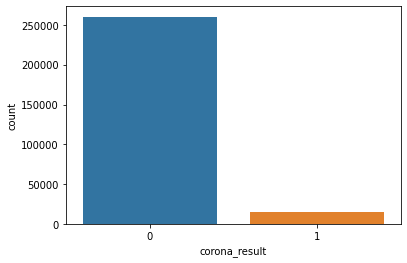

In [ ]:
sns.countplot(data = df, x = 'corona_result')

In [ ]:
X = df.drop('corona_result', axis = 1)
y = df['corona_result']

We use three approaches here:
- Creating model without balancing.
- First downsampling majority column. Then upsampling from minority class randomly
- Using Synthetic Minority Oversampling Technique to upsample and Using TOMEK links to remove overlapping clusters.

#### 1. Data without upsampling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

#### 2. Upsampling random sampling

In [ ]:
train_data = pd.concat([X_train, y_train], axis=1)

In [ ]:
negative = train_data[train_data['corona_result'] == 0]
positive = train_data[train_data['corona_result'] == 1]

In [ ]:
half_of_neg = int(len(negative)/2)

In [ ]:
half_of_neg

104101

In [ ]:
pos_downsampled = resample(negative, replace = True, n_samples = half_of_neg, random_state = 42)

In [ ]:
# upsample minority
pos_upsampled = resample(positive, replace=True, # sample with replacement
                         n_samples=len(pos_downsampled), # match number in majority class
                         random_state=27) # reproducible results

In [ ]:
# combine majority and upsampled minority
upsampled = pd.concat([pos_downsampled, pos_upsampled])

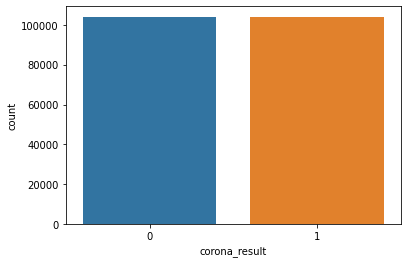

In [ ]:
sns.countplot(data = upsampled, x = 'corona_result')

In [ ]:
upsampled = upsampled.sample(frac = 1)

In [ ]:
upsampled.reset_index(drop = True, inplace = True)

In [ ]:
upsampled.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,test_indication,gender_Other,gender_female,gender_male,corona_result
0,1,0,0,0,0,1,1,0,0,1,0
1,1,1,1,0,0,1,0,0,1,0,1
2,0,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,1
4,1,1,1,1,1,1,0,0,0,1,1


In [ ]:
X_train_up = upsampled.drop('corona_result', axis = 1)
y_train_up = upsampled['corona_result']

#### 3. SMOTE+TOMEK

In [ ]:
counter = y_train.value_counts()
print("Before:", counter)

smtom = SMOTETomek(random_state=42)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)
counter_2 = y_train_smtom.value_counts()
print("After:", counter_2)

Before: 0    208202
1     11762
Name: corona_result, dtype: int64
After: 0    208202
1    208202
Name: corona_result, dtype: int64


#### Metric functions

Writing custom functions to display evaluation metrics better.

In [ ]:
def print_metrics(y_actual, y_predicted):
    print(f'\nAccuracy is: {round(accuracy_score(y_actual, y_predicted), 2)*100}%')
    print(f'\nF1 score is: {round(f1_score(y_actual, y_predicted), 2)*100}%')
    print(f'\nPrecision score is: {round(precision_score(y_actual, y_predicted), 2)*100}%')
    print(f'\nRecall score is: {round(recall_score(y_actual, y_predicted), 2)*100}%')

In [ ]:
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Negative)', 'True 1(positive)'], 
            columns=['Pred 0(Covid Negative)', 
                            'Pred 1(Covid Positive)'])

## Modelling

### Logistic Regression

#### 1. Without upsample

In [ ]:
lr = LogisticRegression()
lr_model = lr.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
print_metrics(y_test, lr_predictions)
conf_matrix(y_test, lr_predictions)


Accuracy is: 96.0%

F1 score is: 56.99999999999999%

Precision score is: 81.0%

Recall score is: 43.0%


,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 51725 (TNR = 99.42%),FP = 300 (FPR = 0.58%)
True 1(positive),FN = 1676 (FNR = 56.51%),TP = 1290 (TPR = 43.49%)


#### 2. With upsample

In [ ]:
lr_2 = LogisticRegression()
lr_model_2 = lr_2.fit(X_train_up, y_train_up)
lr_predictions_2 = lr_model_2.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, lr_predictions_2))
print_metrics(y_test, lr_predictions_2)
conf_matrix(y_test, lr_predictions_2)


Accuracy is: 87.0%

F1 score is: 40.0%

Precision score is: 26.0%

Recall score is: 80.0%


,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 45394 (TNR = 87.25%),FP = 6631 (FPR = 12.75%)
True 1(positive),FN = 583 (FNR = 19.66%),TP = 2383 (TPR = 80.34%)


#### 3. SOMTE+TOMEK

In [ ]:
lr_3 = LogisticRegression()
lr_model_3 = lr_3.fit(X_train_smtom, y_train_smtom)
lr_predictions_3 = lr_model_3.predict(X_test)
print_metrics(y_test, lr_predictions_3)
conf_matrix(y_test, lr_predictions_3)


Accuracy is: 87.0%

F1 score is: 40.0%

Precision score is: 26.0%

Recall score is: 80.0%


,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 45394 (TNR = 87.25%),FP = 6631 (FPR = 12.75%)
True 1(positive),FN = 583 (FNR = 19.66%),TP = 2383 (TPR = 80.34%)


### Support Vector Classifier

In [ ]:
svc = SVC()
svc_model = svc.fit(X_train, y_train)

In [ ]:
svc_predictions = svc_model.predict(X_test)

In [ ]:
confusion_matrix(y_test, svc_predictions)

array([[47486,  4539],
       [  625,  2341]])

In [ ]:
print(f'\nAccuracy is: {round(accuracy_score(y_test, svc_predictions), 2)*100}%')
print(f'\nF1 score is: {round(f1_score(y_test, svc_predictions), 2)*100}%')
print(f'\nPrecision score is: {round(precision_score(y_test, svc_predictions), 2)*100}%')
print(f'\nRecall score is: {round(recall_score(y_test, svc_predictions), 2)*100}%')


Accuracy is: 91.0%

F1 score is: 48.0%

Precision score is: 34.0%

Recall score is: 79.0%


In [ ]:
svc_linear = SVC(kernel='linear')
svc_liner_model = svc_linear.fit(X_train, y_train)

In [ ]:
svc_linear_predictions = svc_liner_model.predict(X_test)

In [ ]:
confusion_matrix(y_test, svc_linear_predictions)

array([[45233,  6792],
       [  562,  2404]])

In [ ]:
print(f'\nAccuracy is: {round(accuracy_score(y_test, svc_linear_predictions), 2)*100}%')
print(f'\nF1 score is: {round(f1_score(y_test, svc_linear_predictions), 2)*100}%')
print(f'\nPrecision score is: {round(precision_score(y_test, svc_linear_predictions), 2)*100}%')
print(f'\nRecall score is: {round(recall_score(y_test, svc_linear_predictions), 2)*100}%')


Accuracy is: 87.0%

F1 score is: 40.0%

Precision score is: 26.0%

Recall score is: 81.0%


In [ ]:
svc_poly = SVC(kernel='poly')
svc_poly_model = svc_poly.fit(X_train, y_train)
svc_poly_predictions = svc_poly_model.predict(X_test)
confusion_matrix(y_test, svc_poly_predictions)

array([[47971,  4054],
       [  666,  2300]])

In [ ]:
print(f'\nAccuracy is: {round(accuracy_score(y_test, svc_poly_predictions), 2)*100}%')
print(f'\nF1 score is: {round(f1_score(y_test, svc_poly_predictions), 2)*100}%')
print(f'\nPrecision score is: {round(precision_score(y_test, svc_poly_predictions), 2)*100}%')
print(f'\nRecall score is: {round(recall_score(y_test, svc_poly_predictions), 2)*100}%')


Accuracy is: 91.0%

F1 score is: 49.0%

Precision score is: 36.0%

Recall score is: 78.0%


Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier()
dtc_model = dtc.fit(X_train, y_train)

In [ ]:
dtc_predictions = dtc_model.predict(X_test)

In [ ]:
confusion_matrix(y_test, dtc_predictions)

array([[47578,  4447],
       [  637,  2329]])

In [ ]:
print(f'\nAccuracy is: {round(accuracy_score(y_test, dtc_predictions), 2)*100}%')
print(f'\nF1 score is: {round(f1_score(y_test, dtc_predictions), 2)*100}%')
print(f'\nPrecision score is: {round(precision_score(y_test, dtc_predictions), 2)*100}%')
print(f'\nRecall score is: {round(recall_score(y_test, dtc_predictions), 2)*100}%')


Accuracy is: 91.0%

F1 score is: 48.0%

Precision score is: 34.0%

Recall score is: 79.0%


### Random Forest Classifier

#### 1. After upsampling

In [ ]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train_up, y_train_up)
rfc_predict = rfc_model.predict(X_test)
conf_matrix(y_test, rfc_predict)

,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 47489 (TNR = 91.28%),FP = 4536 (FPR = 8.72%)
True 1(positive),FN = 627 (FNR = 21.14%),TP = 2339 (TPR = 78.86%)


Train Evaluation

In [ ]:
rfc_up_train_predict = rfc_model.predict(X_train_up)
print_metrics(y_train_up, rfc_up_train_predict)


Accuracy is: 85.0%

F1 score is: 84.0%

Precision score is: 90.0%

Recall score is: 80.0%


Test Evaluation

In [ ]:
print_metrics(y_test, rfc_predict)


Accuracy is: 91.0%

F1 score is: 48.0%

Precision score is: 34.0%

Recall score is: 79.0%


#### 2. Without upsampling

In [ ]:
rfc_2 = RandomForestClassifier()
rfc_model_2 = rfc_2.fit(X_train, y_train)
rfc_predict_2 = rfc_model_2.predict(X_test)
conf_matrix(y_test, rfc_predict_2)

,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 51688 (TNR = 99.35%),FP = 337 (FPR = 0.65%)
True 1(positive),FN = 1351 (FNR = 45.55%),TP = 1615 (TPR = 54.45%)


Train evaluation

In [ ]:
rfc_train_predict = rfc_model_2.predict(X_train)

In [ ]:
print_metrics(y_train, rfc_train_predict)


Accuracy is: 97.0%

F1 score is: 65.0%

Precision score is: 81.0%

Recall score is: 54.0%


Test evaluation

In [ ]:
print_metrics(y_test, rfc_predict_2)


Accuracy is: 97.0%

F1 score is: 66.0%

Precision score is: 83.0%

Recall score is: 54.0%


#### 3. SMOTE+TOMEK

In [ ]:
rfc_3 = RandomForestClassifier()
rfc_model_3 = rfc_3.fit(X_train_smtom, y_train_smtom)
rfc_predict_3 = rfc_model_3.predict(X_test)
conf_matrix(y_test, rfc_predict_3)

,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 47333 (TNR = 90.98%),FP = 4692 (FPR = 9.02%)
True 1(positive),FN = 619 (FNR = 20.87%),TP = 2347 (TPR = 79.13%)


Train Evaluation

In [ ]:
rfc_train_smtom = rfc_model_3.predict(X_train_smtom)
print_metrics(y_train_smtom, rfc_train_smtom)


Accuracy is: 85.0%

F1 score is: 84.0%

Precision score is: 90.0%

Recall score is: 80.0%


Test Evaluation

In [ ]:
print_metrics(y_test, rfc_predict_3)


Accuracy is: 90.0%

F1 score is: 47.0%

Precision score is: 33.0%

Recall score is: 79.0%


### XGBoost

#### 1. Without upsampling

In [ ]:
xgb = XGBClassifier()
eval_set = [X_test, y_test]
xgb_model = xgb.fit(X_train, y_train)
xgb_predict = xgb_model.predict(X_test)
conf_matrix(y_test, xgb_predict)

,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 51680 (TNR = 99.34%),FP = 345 (FPR = 0.66%)
True 1(positive),FN = 1365 (FNR = 46.02%),TP = 1601 (TPR = 53.98%)


Train Evaluation

In [ ]:
xgb_train_predict = xgb_model.predict(X_train)
print_metrics(y_train, xgb_train_predict)


Accuracy is: 97.0%

F1 score is: 65.0%

Precision score is: 80.0%

Recall score is: 54.0%


Test Evaluation

In [ ]:
print_metrics(y_test, xgb_predict)


Accuracy is: 97.0%

F1 score is: 65.0%

Precision score is: 82.0%

Recall score is: 54.0%


#### 2. With Upsampling

In [ ]:
xgb_2 = XGBClassifier()
xgb_model_2 = xgb_2.fit(X_train_up, y_train_up)
xgb_predict_2 = xgb_model_2.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, xgb_predict_2))

,0,1
0,47296,4729
1,616,2350


Train Evaluation

In [ ]:
xgb_train_predict = xgb_model_2.predict(X_train)
print_metrics(y_train, xgb_train_predict)


Accuracy is: 90.0%

F1 score is: 47.0%

Precision score is: 33.0%

Recall score is: 80.0%


Test Evaluation

In [ ]:
print_metrics(y_test, xgb_predict_2)


Accuracy is: 90.0%

F1 score is: 47.0%

Precision score is: 33.0%

Recall score is: 79.0%


#### 2. SMOTE+TOMEK

In [ ]:
xgb_3 = XGBClassifier(use_label_encoder=False)
xgb_model_3 = xgb_3.fit(X_train_smtom, y_train_smtom, eval_metric = 'error')
xgb_predict_3 = xgb_model_3.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, xgb_predict_3))

,0,1
0,47490,4535
1,627,2339


In [ ]:
conf_matrix(y_test, xgb_predict_3)

,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 47490 (TNR = 91.28%),FP = 4535 (FPR = 8.72%)
True 1(positive),FN = 627 (FNR = 21.14%),TP = 2339 (TPR = 78.86%)


Train Evaluation

In [ ]:
xgb_train_predict = xgb_model_3.predict(X_train)
print_metrics(y_train, xgb_train_predict)


Accuracy is: 91.0%

F1 score is: 47.0%

Precision score is: 34.0%

Recall score is: 80.0%


Test Evaluation

In [ ]:
print_metrics(y_test, xgb_predict_3)


Accuracy is: 91.0%

F1 score is: 48.0%

Precision score is: 34.0%

Recall score is: 79.0%


### Insights:
- After using several classification models, RandomForest, XGBoost and Logistic Regression seems to perform better.
- However we have to adjust False Negatives to reduce number of Covid Positive cases being classified as negative

### ROC-AUC Score

#### Random Forest

In [ ]:
rfc_probs = rfc_model_3.predict_proba(X_test)
rfc_yhat = rfc_probs[:, 1]
rfc_yhat

array([0.76795111, 0.1263913 , 0.17623653, ..., 0.17623653, 0.16546467,
       0.1263913 ])

In [ ]:
roc_auc_score(y_test, rfc_yhat)

0.902295601957537

#### XGBoost

In [ ]:
xgb_probs = xgb_model_3.predict_proba(X_test)
xgb_yhat = xgb_probs[:, 1]
xgb_yhat

array([0.76732004, 0.12629865, 0.17607032, ..., 0.17607032, 0.16490021,
       0.12629865], dtype=float32)

In [ ]:
roc_auc_score(y_test, xgb_yhat)

0.9025193065862896

#### Logistic Regression

In [ ]:
lr_probs = lr_model_3.predict_proba(X_test)
lr_yhat = lr_probs[:, 1]
lr_yhat

array([0.88486808, 0.15277062, 0.20267383, ..., 0.20267383, 0.20152885,
       0.15277062])

In [ ]:
roc_auc_score(y_test, lr_yhat)

0.8873738506209895

- AUC scores are close for the three models.
- RandomForest and XGBoost have slighlty higher values

### Hyperparameter tuning using hyperopt

#### 1. XGBoost

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 1,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    clf = XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'], use_label_encoder=False, 
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train_smtom, y_train_smtom), ( X_test, y_test)]
    
    clf.fit(X_train_smtom, y_train_smtom,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    recall = recall_score(y_test, pred)
    print ("SCORE:", recall)
    return {'loss': 1-recall, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.7319622387053271
SCORE:
0.731

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7832978651599605, 'gamma': 8.954177492018587, 'max_depth': 7.0, 'min_child_weight': 6.0, 'reg_alpha': 122.0, 'reg_lambda': 0.5732676360974758}


In [ ]:
xgb_tuned = XGBClassifier(max_depth = 7, n_estimators=180, gamma=8.9542, min_child_weight=6.0, 
                          colsample_bytree=0.7833, reg_alpha = 122.0, reg_lambda=0.5733, use_label_encoder=False)
xgb_tuned_model = xgb_tuned.fit(X_train_smtom, y_train_smtom, eval_metric='error')
xgb_tuned_predict = xgb_tuned_model.predict(X_test)
conf_matrix(y_test, xgb_tuned_predict)

,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 47468 (TNR = 91.24%),FP = 4557 (FPR = 8.76%)
True 1(positive),FN = 622 (FNR = 20.97%),TP = 2344 (TPR = 79.03%)


In [ ]:
print_metrics(y_test, xgb_tuned_predict)


Accuracy is: 91.0%

F1 score is: 48.0%

Precision score is: 34.0%

Recall score is: 79.0%


Hyperparameter optimization failed to improve our model. So we can use a Voting Classifier to combine the three best models.

### Voting Classifier

In [ ]:
estimator =[]
estimator.append(('LR', LogisticRegression()))
estimator.append(('RFC', RandomForestClassifier()))
estimator.append(('XGB', XGBClassifier()))

In [ ]:
estimator

[('LR', LogisticRegression()),
 ('RFC', RandomForestClassifier()),
 ('XGB', XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None,
                enable_categorical=False, gamma=None, gpu_id=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=None, reg_alpha=None,
                reg_lambda=None, scale_pos_weight=None, subsample=None,
                tree_method=None, validate_parameters=None, verbosity=None))]

#### 1. Hard Voting

In [ ]:
from matplotlib.cbook import print_cycles
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
voting_model_hard = vot_hard.fit(X_train_smtom, y_train_smtom)
y_pred = voting_model_hard.predict(X_test)
print_metrics(y_test, y_pred)
conf_matrix(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:37:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Accuracy is: 91.0%

F1 score is: 48.0%

Precision score is: 34.0%

Recall score is: 79.0%


,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 47490 (TNR = 91.28%),FP = 4535 (FPR = 8.72%)
True 1(positive),FN = 627 (FNR = 21.14%),TP = 2339 (TPR = 78.86%)


#### 2. Soft Voting

In [ ]:
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
voting_model_soft = vot_soft.fit(X_train_smtom, y_train_smtom)
y_pred = voting_model_soft.predict(X_test)
print_metrics(y_test, y_pred)
conf_matrix(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:38:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Accuracy is: 90.0%

F1 score is: 47.0%

Precision score is: 33.0%

Recall score is: 79.0%


,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 47321 (TNR = 90.96%),FP = 4704 (FPR = 9.04%)
True 1(positive),FN = 628 (FNR = 21.17%),TP = 2338 (TPR = 78.83%)


#### ROC-AUC Score

In [ ]:
vote_probs = voting_model_soft.predict_proba(X_test)
vote_yhat = vote_probs[:, 1]
vote_yhat

array([0.7709414 , 0.13822543, 0.18572887, ..., 0.18572887, 0.17765869,
       0.13822543])

In [ ]:
roc_auc_score(y_test, vote_yhat)

0.9027442878977927

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, vote_yhat)

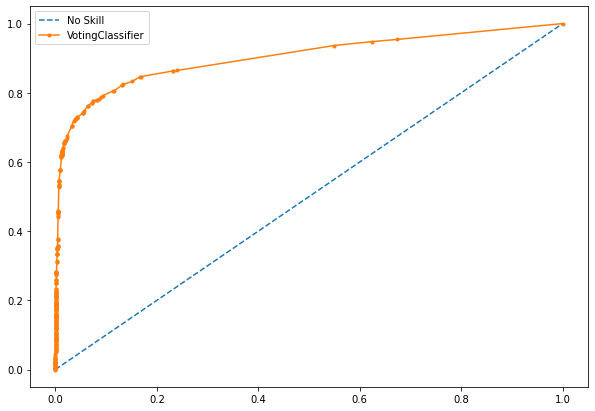

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='VotingClassifier')
plt.legend()

#### Adjusting Threshold value

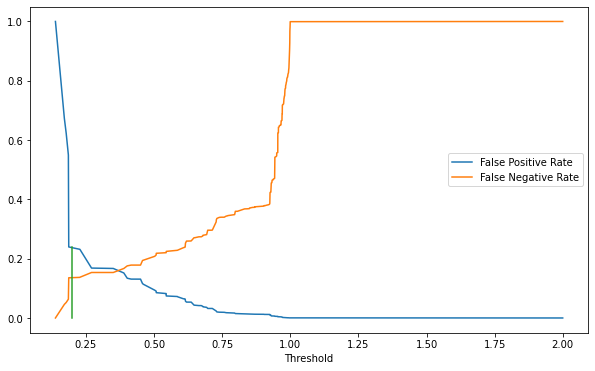

In [ ]:
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))
ax.plot([0.2,0.2],[0,0.24]) #mark example thresh.

In [ ]:
tuned_pred = np.where(vote_yhat > 0.15, 1, 0)

print_metrics(y_test, tuned_pred)
conf_matrix(y_test, tuned_pred)


Accuracy is: 36.0%

F1 score is: 14.000000000000002%

Precision score is: 7.000000000000001%

Recall score is: 95.0%


,Pred 0(Covid Negative),Pred 1(Covid Positive)
True 0(Negative),TN = 17001 (TNR = 32.68%),FP = 35024 (FPR = 67.32%)
True 1(positive),FN = 136 (FNR = 4.59%),TP = 2830 (TPR = 95.41%)


- Even after using voting classifier, we were unable to improve out model.
- Further, adjusting the threshold value reduces the accuracy and precision unacceptably though recall is raised to 95%.

### Saving Model

We decided to select the RandomForest model trained on the upsampled SMOTE+TOMEK data to build and deploy our web application because it gave the lowest false negatives out of all trials and recall value is 80% which though not good, is acceptable.

In [ ]:
import pickle

In [ ]:
#pickle.dump(rfc_model_3, open('/content/drive/MyDrive/Project/model.pkl', 'wb'))

[Self test app based on model](http://covidselftest17.herokuapp.com/)

########## ################ ######################